### Check *analytical* pipeline differences after dates alignment by comparing results with reference outputs at the district level

In [1]:
%cd ../../

/home/u/amine.barkaoui/anticipatory-action


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
from config.params import Params

Prepare input data

In [4]:
country = "MOZ"

In [5]:
params = Params(iso=country, index='SPI')

### Comparison on the full output at the district level

In [6]:
def plot_hist(comparison, title, xlabel, xmin, xmax, s=1, mask_text=False):
    fig, ax = plt.subplots(figsize = (6,4))

    quant_5, quant_25, quant_50, quant_75, quant_95 = comparison.difference.quantile(0.05), comparison.difference.quantile(0.25), comparison.difference.quantile(0.5), comparison.difference.quantile(0.75), comparison.difference.quantile(0.95)

    # [quantile, opacity, length]
    quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

    comparison.difference.plot(kind='hist', density = True, alpha = 0.65, bins=200)
    comparison.difference.plot(kind='kde')

    # Plot the lines with a loop
    for i in quants: plt.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

    # X
    ax.set_xlabel(xlabel)
    ax.set_xlim(xmin, xmax) 

    # Y
    ax.set_yticklabels([])
    ax.set_ylabel("")

    if not(mask_text):
        plt.text(quant_5-.01, 0.15 * s, "5th", size = 10, alpha = 0.8)
        plt.text(quant_25-.013, 0.27 * s, "25th", size = 11, alpha = 0.85)
        plt.text(quant_50-.013, 0.33 * s, "50th", size = 12, alpha = 1)
        plt.text(quant_75-.013, 0.39 * s, "75th", size = 11, alpha = 0.85)
        plt.text(quant_95-.025, 0.47 * s, "95th Percentile", size = 10, alpha =.8)

    # Overall
    ax.grid(False)
    ax.set_title(title, size = 17, pad = 10)

    # Remove ticks and spines
    ax.tick_params(left = False, bottom = False)
    for ax, spine in ax.spines.items():
        spine.set_visible(False)

In [7]:
fbfref = pd.read_csv(f"{params.data_path}/data/{params.iso}/auc/fbf.districts.roc.{params.index}.{params.calibration_year}.csv")
fbfref = fbfref.rename(columns={'AUC_best': 'AUC_ref', 'BC': 'BC_ref'})
fbfref

,district,category,AUC_ref,BC_ref,Index,issue
0,Ancuabe,Severe,0.414491,0,SPI MJ,5
1,Ancuabe,Moderate,0.427711,0,SPI MJ,5
2,Ancuabe,Mild,0.593641,0,SPI MJ,5
3,Balama,Severe,0.579435,0,SPI MJ,5
4,Balama,Moderate,0.603180,0,SPI MJ,5
...,...,...,...,...,...,...
33721,Nicoadala,Moderate,0.646129,0,SPI AMJ,2
33722,Nicoadala,Mild,0.579163,0,SPI AMJ,2
33723,Pebane,Severe,0.507421,0,SPI AMJ,2
33724,Pebane,Moderate,0.561913,0,SPI AMJ,2


In [8]:
fbf_aligned = pd.read_csv(f"{params.data_path}/data/{params.iso}_align_dates/auc/fbf.districts.roc.{params.index}.{params.calibration_year}.csv")
fbf_aligned

,district,category,AUC_best,BC,Index,issue
0,Ancuabe,Severe,0.784348,1,SPI JF,1
1,Ancuabe,Moderate,0.754190,1,SPI JF,1
2,Ancuabe,Mild,0.723348,1,SPI JF,1
3,Balama,Severe,0.792063,1,SPI JF,1
4,Balama,Moderate,0.718328,1,SPI JF,1
...,...,...,...,...,...,...
32845,Nicoadala,Moderate,0.537165,0,SPI DJF,12
32846,Nicoadala,Mild,0.571750,0,SPI DJF,12
32847,Pebane,Severe,0.615295,1,SPI DJF,12
32848,Pebane,Moderate,0.596827,1,SPI DJF,12


Ratio of bias-corrected values in the final output

In [9]:
# Ratio of cases using Bias Correction
fbf_aligned.BC.sum() / len(fbf_aligned)

0.21838660578386607

Histogram of difference between full outputs (auc_to_compare - python_reference)

In [10]:
comparison = fbf_aligned.set_index(['district', 'category', 'Index', 'issue']).join(fbfref.set_index(['district', 'category', 'Index', 'issue'])).reset_index()

In [11]:
comparison['difference'] = comparison.AUC_best - comparison.AUC_ref

In [12]:
# Filter comparison on pilot districts
comparison = comparison.loc[comparison.district.isin(params.districts)]

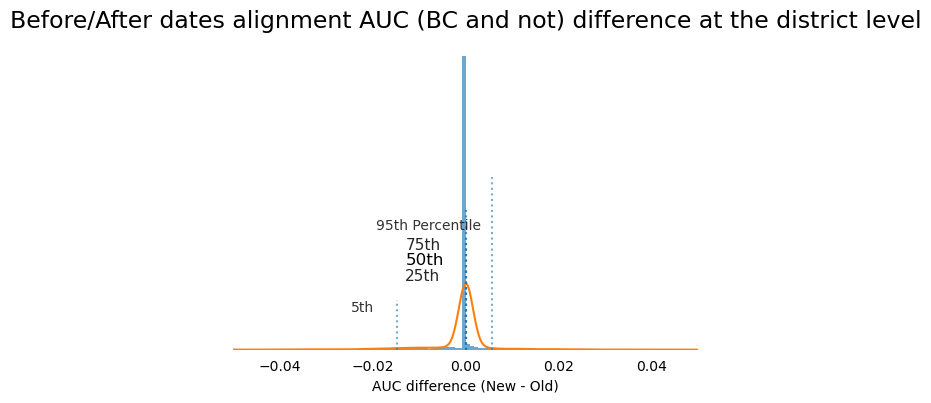

In [15]:
plot_hist(comparison, title="Before/After dates alignment AUC (BC and not) difference at the district level", xlabel="AUC difference (New - Old)", xmin=-.05, xmax=.05, s=800)


### Difference (auc_to_compare - python_reference) on the full output by category / district / index / issue

Text(0.5, 0.98, 'SEVERE CATEGORY')

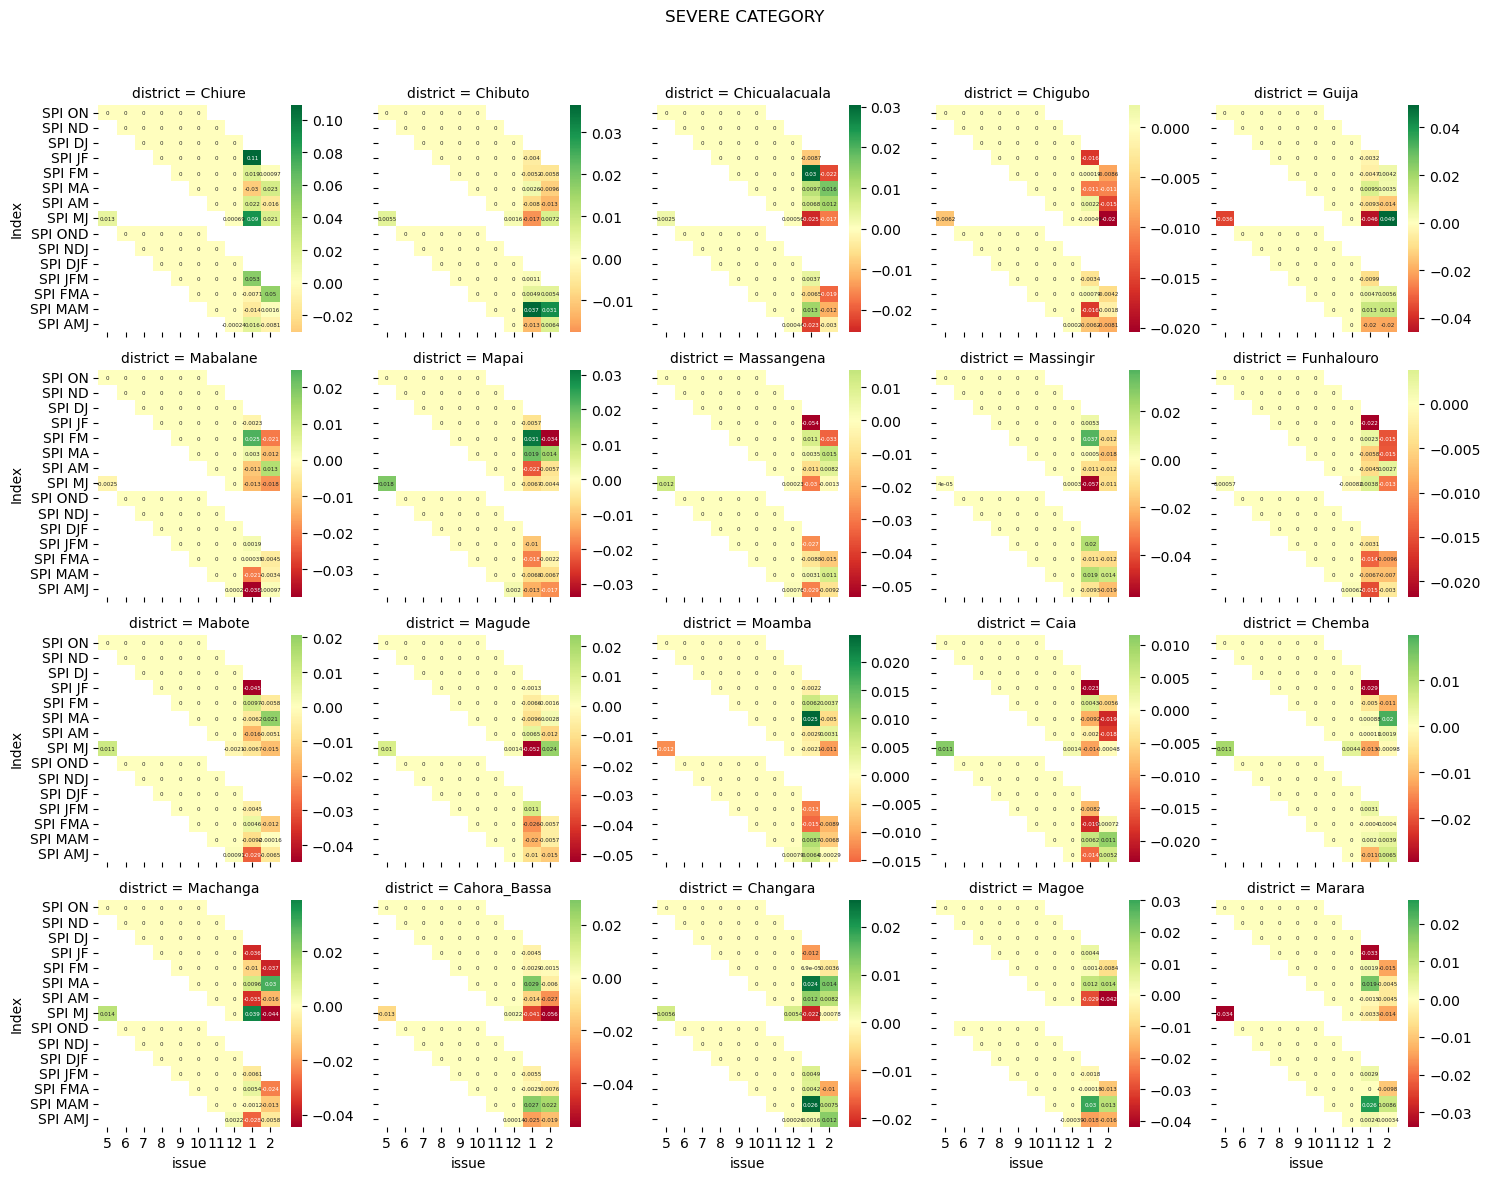

In [16]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI MJ', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM', 'SPI AMJ']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(comparison.loc[(comparison.category=='Severe')], col='district', col_wrap=5)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('SEVERE CATEGORY')

Text(0.5, 0.98, 'MODERATE CATEGORY')

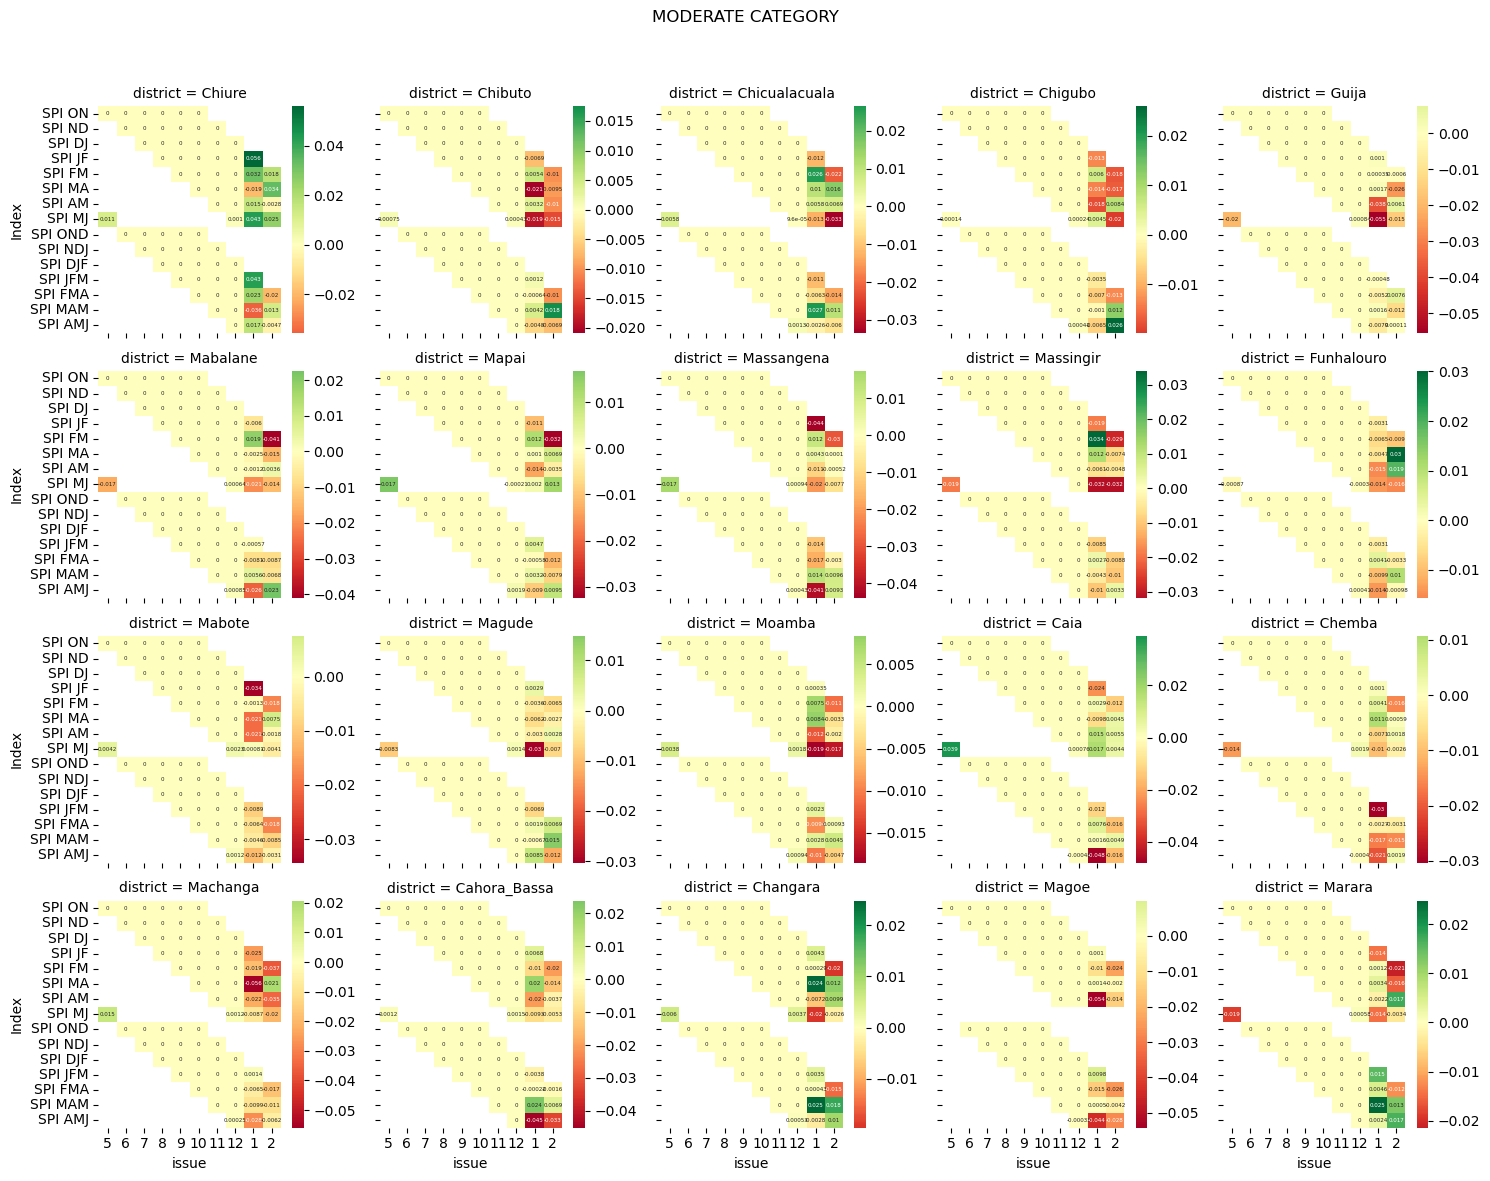

In [17]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Moderate')], col='district', col_wrap=5)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MODERATE CATEGORY')

Text(0.5, 0.98, 'MILD CATEGORY')

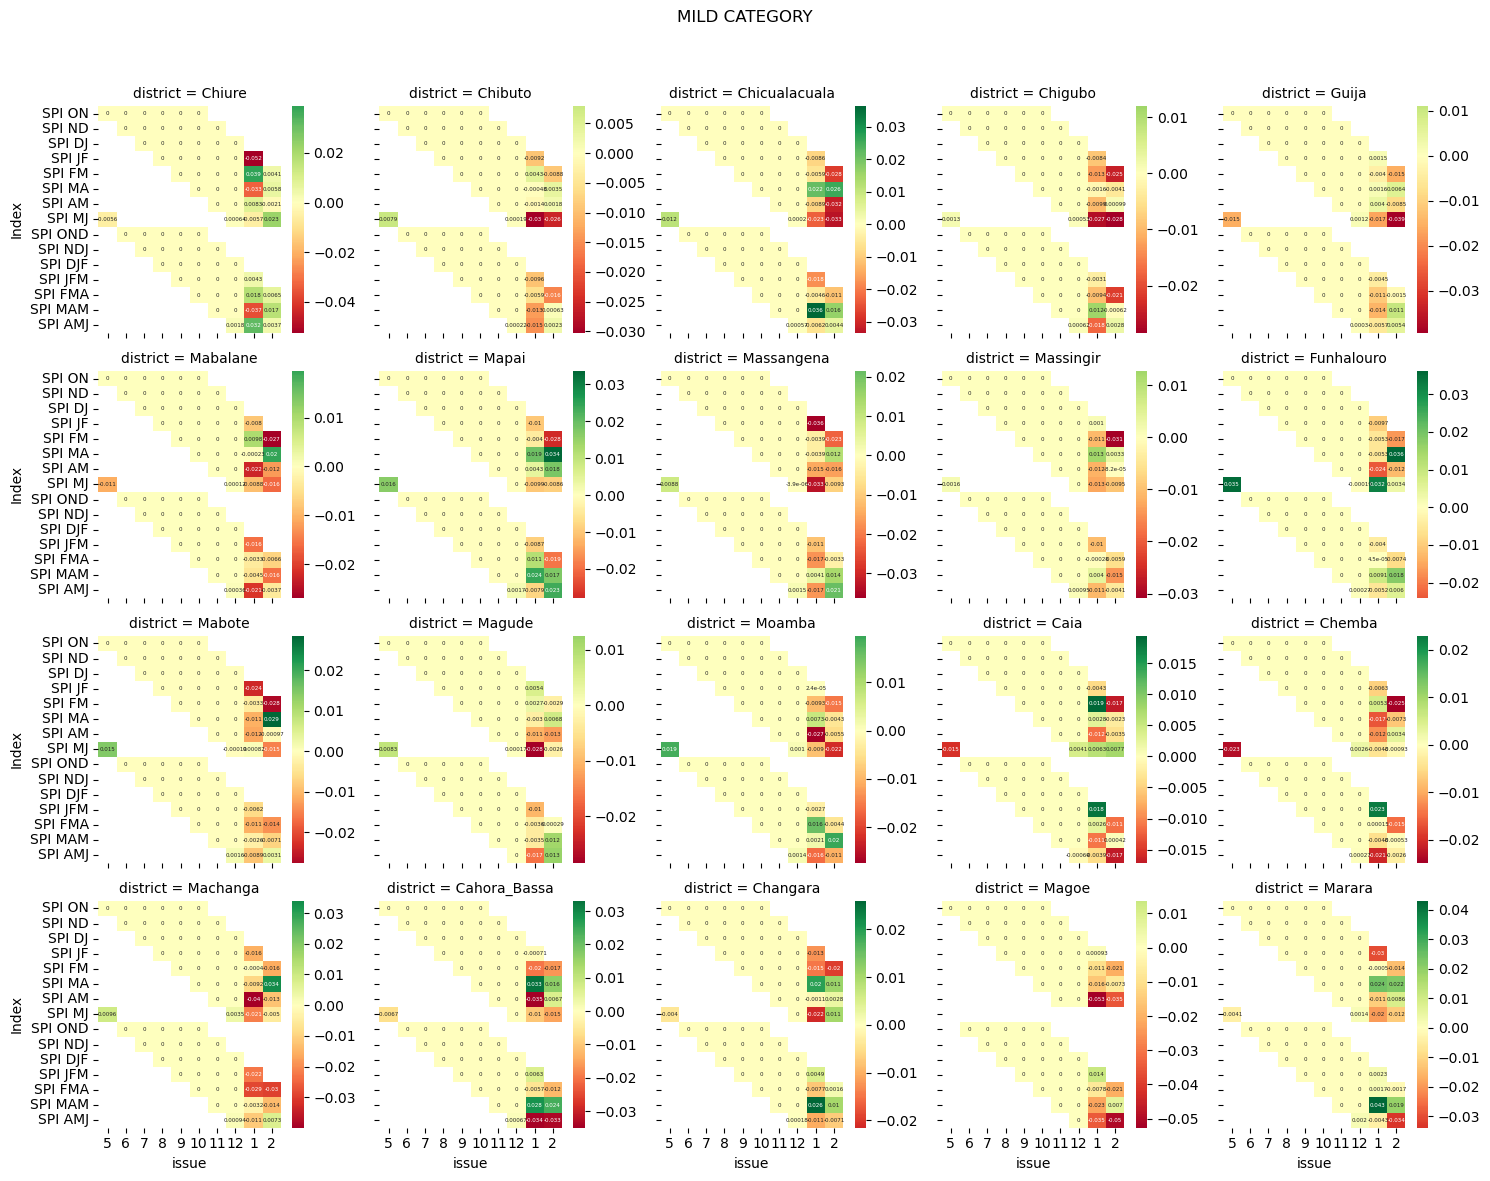

In [18]:
fg = sns.FacetGrid(comparison.loc[(comparison.category=='Mild')], col='district', col_wrap=5)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)
fg.fig.subplots_adjust(top=0.9)
fg.fig.suptitle('MILD CATEGORY')

### Visualisation of differences for each pair of variables to highlight any systematic difference

**Average difference**

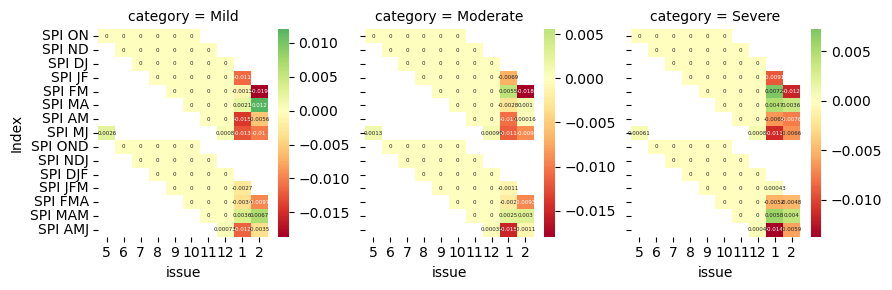

In [19]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI MJ', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM', 'SPI AMJ']

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="Index", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'Index', 'category']).mean('district').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

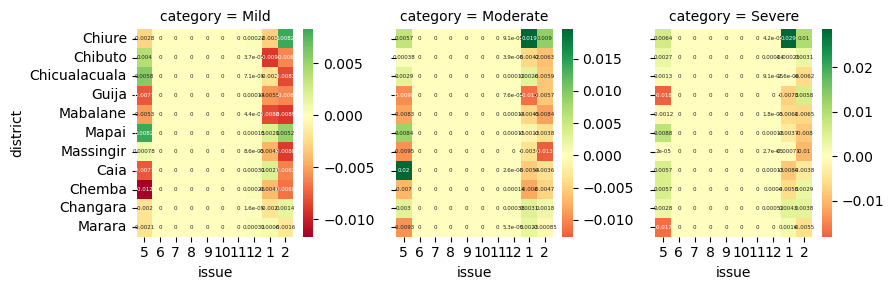

In [20]:
x_axis = [5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="issue", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['issue', 'district', 'category']).mean('Index').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)

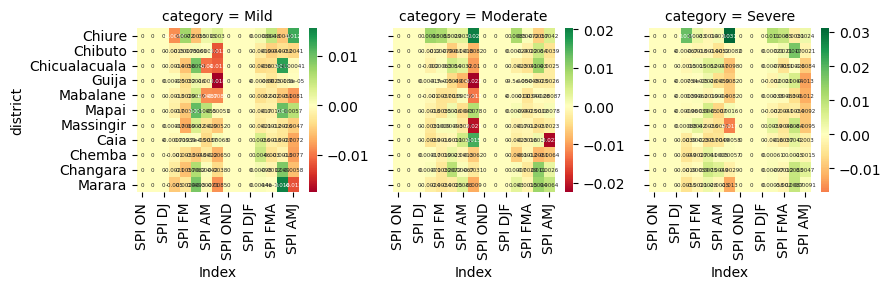

In [21]:
x_axis = ['SPI ON', 'SPI ND', 'SPI DJ', 'SPI JF', 'SPI FM', 'SPI MA', 'SPI AM', 'SPI MJ', 'SPI OND', 'SPI NDJ', 'SPI DJF', 'SPI JFM', 'SPI FMA', 'SPI MAM', 'SPI AMJ']
y_axis = ["Chiure", "Chibuto", "Chicualacuala", "Guija", "Mabalane", "Mapai", "Massingir", "Caia", "Chemba", "Changara", "Marara"]

def draw_heatmap(**kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index="district", columns="Index", values="difference")
    d = d.reindex(index=y_axis, columns=x_axis)
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(
    comparison.groupby(['Index', 'district', 'category']).mean('issue').reset_index(), 
    col='category', 
    col_wrap=3
)
fg.map_dataframe(draw_heatmap, annot=True, annot_kws={"size":4}, cbar=True, cmap='RdYlGn', center=0)